By using Linear Regression, how the selling price of a HDB resale flat changes based on the following:<br>
* its distance to the CBD
* its distance to the nearest MRT station
* its flat size
* its floor level
* the years of lease remaining on the flat

HDB Dataset is from data.gov.sg as of 3 May 2021

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('combined.csv')
df

C:\Users\Jim\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,latitude,longitude,blk_no,road_name,postal_code,address,cbd_dist,min_dist_mrt,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,lease_remain_years
0,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.721074,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,255000.0,70,64
1,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.721074,2015-12,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,10 TO 12,60.0,Improved,1986,275000.0,69,64
2,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.721074,2016-05,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,69.0,Improved,1986,310000.0,68,64
3,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.721074,2016-06,ANG MO KIO,2 ROOM,174,ANG MO KIO AVE 4,07 TO 09,45.0,Improved,1986,253000.0,68,64
4,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.721074,2016-11,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,290000.0,68,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133890,1.415662,103.841449,511A,YISHUN STREET 51,761511,511A YISHUN ST 51,14710.032665,961.464116,2021-03,YISHUN,5 ROOM,511A,YISHUN ST 51,10 TO 12,113.0,Improved,2017,625000.0,95 years 06 months,95
133891,1.415662,103.841449,511A,YISHUN STREET 51,761511,511A YISHUN ST 51,14710.032665,961.464116,2021-04,YISHUN,5 ROOM,511A,YISHUN ST 51,07 TO 09,113.0,Improved,2017,575000.0,95 years 04 months,95
133892,1.415662,103.841449,511A,YISHUN STREET 51,761511,511A YISHUN ST 51,14710.032665,961.464116,2021-04,YISHUN,5 ROOM,511A,YISHUN ST 51,07 TO 09,113.0,Improved,2017,610000.0,95 years 05 months,95
133893,1.412531,103.834228,819,YISHUN STREET 81,760819,819 YISHUN ST 81,14448.324527,554.248877,2021-04,YISHUN,4 ROOM,819,YISHUN ST 81,01 TO 03,104.0,Model A,1987,420000.0,65 years 07 months,65


In [3]:
df.dtypes

latitude               float64
longitude              float64
blk_no                  object
road_name               object
postal_code             object
address                 object
cbd_dist               float64
min_dist_mrt           float64
month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
remaining_lease         object
lease_remain_years       int64
dtype: object

In [4]:
# Just to reconfirm their data types after loading the cleaned data

df['resale_price'] = df['resale_price'].astype('float')
df['floor_area_sqm'] = df['floor_area_sqm'].astype('float')
df['lease_commence_date'] = df['lease_commence_date'].astype('int64')
df['lease_remain_years'] = df['lease_remain_years'].astype('int64')

df.dtypes

latitude               float64
longitude              float64
blk_no                  object
road_name               object
postal_code             object
address                 object
cbd_dist               float64
min_dist_mrt           float64
month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
remaining_lease         object
lease_remain_years       int64
dtype: object

Get the numerical value of the storeys of each flat by using median value of the storey range:

In [5]:
import statistics

def get_median(x):
    split_list = x.split(' TO ')
    float_list = [float(i) for i in split_list]
    median = statistics.median(float_list)
    return median

In [6]:
df['storey_median'] = df['storey_range'].apply(lambda x: get_median(x))
df

,latitude,longitude,blk_no,road_name,postal_code,address,cbd_dist,min_dist_mrt,month,town,...,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,lease_remain_years,storey_median
0,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.721074,2015-01,ANG MO KIO,...,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,255000.0,70,64,8.0
1,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.721074,2015-12,ANG MO KIO,...,174,ANG MO KIO AVE 4,10 TO 12,60.0,Improved,1986,275000.0,69,64,11.0
2,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.721074,2016-05,ANG MO KIO,...,174,ANG MO KIO AVE 4,04 TO 06,69.0,Improved,1986,310000.0,68,64,5.0
3,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.721074,2016-06,ANG MO KIO,...,174,ANG MO KIO AVE 4,07 TO 09,45.0,Improved,1986,253000.0,68,64,8.0
4,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.721074,2016-11,ANG MO KIO,...,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,290000.0,68,64,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133890,1.415662,103.841449,511A,YISHUN STREET 51,761511,511A YISHUN ST 51,14710.032665,961.464116,2021-03,YISHUN,...,511A,YISHUN ST 51,10 TO 12,113.0,Improved,2017,625000.0,95 years 06 months,95,11.0
133891,1.415662,103.841449,511A,YISHUN STREET 51,761511,511A YISHUN ST 51,14710.032665,961.464116,2021-04,YISHUN,...,511A,YISHUN ST 51,07 TO 09,113.0,Improved,2017,575000.0,95 years 04 months,95,8.0
133892,1.415662,103.841449,511A,YISHUN STREET 51,761511,511A YISHUN ST 51,14710.032665,961.464116,2021-04,YISHUN,...,511A,YISHUN ST 51,07 TO 09,113.0,Improved,2017,610000.0,95 years 05 months,95,8.0
133893,1.412531,103.834228,819,YISHUN STREET 81,760819,819 YISHUN ST 81,14448.324527,554.248877,2021-04,YISHUN,...,819,YISHUN ST 81,01 TO 03,104.0,Model A,1987,420000.0,65 years 07 months,65,2.0


Focus on our problem statement:

In [7]:
scope_df = df[['cbd_dist','min_dist_mrt','floor_area_sqm','lease_remain_years','storey_median','resale_price']]
scope_df

,cbd_dist,min_dist_mrt,floor_area_sqm,lease_remain_years,storey_median,resale_price
0,10296.855747,1098.721074,60.0,64,8.0,255000.0
1,10296.855747,1098.721074,60.0,64,11.0,275000.0
2,10296.855747,1098.721074,69.0,64,5.0,310000.0
3,10296.855747,1098.721074,45.0,64,8.0,253000.0
4,10296.855747,1098.721074,61.0,64,5.0,290000.0
...,...,...,...,...,...,...
133890,14710.032665,961.464116,113.0,95,11.0,625000.0
133891,14710.032665,961.464116,113.0,95,8.0,575000.0
133892,14710.032665,961.464116,113.0,95,8.0,610000.0
133893,14448.324527,554.248877,104.0,65,2.0,420000.0


In [8]:
scope_df = scope_df.drop_duplicates()
scope_df

,cbd_dist,min_dist_mrt,floor_area_sqm,lease_remain_years,storey_median,resale_price
0,10296.855747,1098.721074,60.0,64,8.0,255000.0
1,10296.855747,1098.721074,60.0,64,11.0,275000.0
2,10296.855747,1098.721074,69.0,64,5.0,310000.0
3,10296.855747,1098.721074,45.0,64,8.0,253000.0
4,10296.855747,1098.721074,61.0,64,5.0,290000.0
...,...,...,...,...,...,...
133890,14710.032665,961.464116,113.0,95,11.0,625000.0
133891,14710.032665,961.464116,113.0,95,8.0,575000.0
133892,14710.032665,961.464116,113.0,95,8.0,610000.0
133893,14448.324527,554.248877,104.0,65,2.0,420000.0


In [9]:
scope_df.dtypes

cbd_dist              float64
min_dist_mrt          float64
floor_area_sqm        float64
lease_remain_years      int64
storey_median         float64
resale_price          float64
dtype: object

Correlation Analysis

<AxesSubplot:>

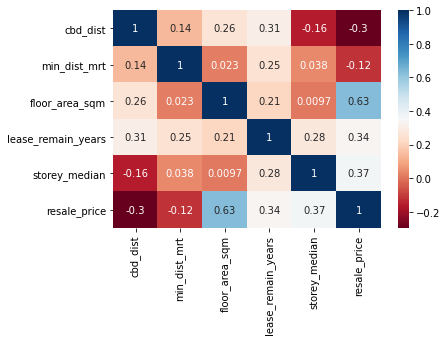

In [10]:
import seaborn as sns

corrMatrix = scope_df.corr()
sns.heatmap(corrMatrix, 
        xticklabels=corrMatrix.columns,
        yticklabels=corrMatrix.columns,
        cmap='RdBu', # https://matplotlib.org/stable/tutorials/colors/colormaps.html
        annot=True)

Linear Regression

In [32]:
from sklearn.model_selection import train_test_split

X=scope_df.to_numpy()[:,:-1]
y=scope_df.to_numpy()[:,-1]

X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=42,test_size=0.25) #consider 25% of data for prediction purpose

In [33]:
from sklearn.linear_model import LinearRegression

line = LinearRegression()
line.fit(X_train,y_train)
(line.intercept_,line.coef_)

(-48925.37523970904,
 array([ -18.14565646,  -49.19201483, 4353.76357578, 4071.59667132,
        5030.45524528]))

In [34]:
def MSE(ys, y_hats):
    # ys, and y_hats are a np.array() with shape (n,)
    n = len(ys)
    differences = ys - y_hats
    squared_diffs = differences ** 2
    summed_squared_differences = sum(squared_diffs)
    return (1/n) * summed_squared_differences

In [35]:
MSE(line.predict(X_train),y_train)

4490363021.170545

In [36]:
line.score(X_train, y_train)

0.8027920069011848

OLS Regression Results

In [26]:
import statsmodels.api as sm

X = scope_df[['cbd_dist','min_dist_mrt','floor_area_sqm','lease_remain_years','storey_median']]
y = scope_df["resale_price"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                 1.054e+05
Date:                Thu, 26 Aug 2021   Prob (F-statistic):               0.00
Time:                        15:13:19   Log-Likelihood:            -1.6201e+06
No. Observations:              129289   AIC:                         3.240e+06
Df Residuals:                  129283   BIC:                         3.240e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -5.019e+04   1208.848    -41.516      0.000   -5.26e+04   -4.78e+04
cbd_dist             -18.1234      0.047   -385.423      0.000     -18.216     -18.031
min_dist_mrt         -49.0360      0.419   -117.148      0.000     -49.856     -48.216
floor_area_sqm      4353.1309      8.069    539.519      0.000    4337.317    4368.945
lease_remain_years  4079.2540     17.117    238.322      0.000    4045.706    4112.802
storey_median       5065.9509     35.130    144.205      0.000    4997.096    5134.806
==============================================================================
Omnibus:                    16226.008   Durbin-Watson:                   0.443
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31908.710
Skew:                           0.801   Prob(JB):                         0.00
Kurtosis:                       4.833   Cond. No.                     8.58e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Regression Error Metrics

In [27]:
summary = scope_df.describe()
summary = summary.transpose()
summary

,count,mean,std,min,25%,50%,75%,max
cbd_dist,129289.0,12422.999110,4423.739293,592.121638,9649.619130,13255.073968,15528.303516,2.022510e+04
min_dist_mrt,129289.0,818.390018,461.510942,23.537905,468.600734,729.173902,1082.522326,3.496403e+03
floor_area_sqm,129289.0,97.903628,24.190423,31.000000,82.000000,95.000000,113.000000,2.800000e+02
lease_remain_years,129289.0,71.608915,12.607352,44.000000,62.000000,71.000000,80.000000,9.700000e+01
storey_median,129289.0,8.526820,5.723530,2.000000,5.000000,8.000000,11.000000,5.000000e+01
resale_price,129289.0,446030.910292,150840.524493,140000.000000,340000.000000,415000.000000,520000.000000,1.258000e+06


In [38]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(scope_df["resale_price"], predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(scope_df["resale_price"], predictions)))

Mean Absolute Error: 51060.924629381385
Root Mean Squared Error: 66948.4376270297


Generate VIFs

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    vif = pd.DataFrame()
    vif["explanatory variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

calc_vif(X)

,explanatory variables,VIF
0,const,42.150601
1,cbd_dist,1.248078
2,min_dist_mrt,1.076423
3,floor_area_sqm,1.098839
4,lease_remain_years,1.343196
5,storey_median,1.166134
